In [2]:
import numpy as np
import pandas as pd
from ast import literal_eval
import json
from os.path import exists

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
models_ran = [
    'LC_discrete_att',
    'change_obs_fk',
    #'change_d_obs_cause_effect',
    #'change_d_obs_cause',
    'LC_discrete',
    'normative',
    'ces_strength',
    'ces_no_strength'
]

file_tags = [
    ['att', 'att_prior'],
    ['att_cha', 'att_cha_prior'],
    #['att_cha'],
    #['att_cha'],
    [1, 'prior'],
    [1, 'prior'],
    ['str_guess'],
    ['guess']
]

model_labels = [
    ['LC w. attention', 'LC w. attention w. prior'],
    ['Change w. full knowledge', 'Change w. full knowledge w. prior'],
    #['Change linear cause effect'],
    #['Change linear cause'],
    ['LC basic', 'LC basic w. prior'],
    ['normative', 'normative w. prior'],
    ['CES strength sensitive'],
    ['CES basic']
]

model_names = []
for names in model_labels:
    model_names += names

color_dict = {
    'LC w. attention': tuple(sns.light_palette("seagreen")[-1]), 
    'LC w. attention w. prior': tuple(sns.light_palette("seagreen")[-2]),
    'Change w. full knowledge': tuple(sns.color_palette("mako")[1]), 
    'Change w. full knowledge w. prior': tuple(sns.color_palette("mako")[2]),
    'Change linear cause effect': tuple(sns.color_palette("mako")[3]),
    'Change linear cause': tuple(sns.color_palette("mako")[4]),
    'LC basic': tuple(sns.color_palette("Paired")[5]),
    'LC basic w. prior': tuple(sns.color_palette("Paired")[4]),
    'normative': tuple(sns.color_palette("Set2")[-3]), 
    'normative w. prior': tuple(sns.color_palette("Paired")[-2]),
    'CES strength sensitive': tuple(sns.color_palette("YlOrBr")[4]),
    'CES basic': tuple(sns.color_palette("YlOrBr")[3]),
    'Baseline': tuple(sns.color_palette("Set2")[-1])
}
# CES prior : sns.color_palette("YlOrBr").as_hex()[3]
# CES strength insensitive: sns.color_palette("YlOrBr").as_hex()[2]

## Dictionary for color allocation
def gen_colors(labels, color_dict):
    return [color_dict[label] for label in labels]

experiments = ['experiment_1', 'experiment_2', 'experiment_3']

In [4]:
def compute_group_bic(nLL, tag, num_trials):

    full_nLL = nLL * num_trials
    data_pen = np.log(num_trials)

    num_params = 1 if tag == 1 else len(tag.split('_'))
    return full_nLL * 2 + data_pen * (1 + num_params)

# Import datasets
df = pd.DataFrame()
for i, model in enumerate(models_ran):
    for j, tag in enumerate(file_tags[i]):
        file_path = f'./data/params_fitting_outputs/{model}/summary_fit_{tag}.csv'
        if exists(file_path):
            good_path = file_path
        else:
            good_path = f'./data/params_fitting_outputs/{model}/exp123_{model}_&_{tag}.csv'
        if df.empty:        
            df = pd.read_csv(good_path)
            df = df.replace([model], [model_labels[i][j]])
            df['tag'] = tag
            df['folder'] = model
    
        else:
            df_2 = pd.read_csv(good_path)
            df_2 = df_2.replace([model], [model_labels[i][j]])
            df_2['tag'] = tag
            df_2['folder'] = model
            df = pd.concat([df, df_2], axis=0, ignore_index=True)


experiments_series = df_2.experiment.to_list()
#df = df.drop(['Unnamed: 0'], axis=1)

num_trials = np.array([239, 484, 482])

df_group = pd.DataFrame()
for i, model in enumerate(models_ran): 
    for j, tag in enumerate(file_tags[i]):
        for k, experiment in enumerate(['experiment_1', 'experiment_2', 'experiment_3']):
            file_path = f'./data/group_params_fitting_outputs/exp{experiment[-1]}_{model}_&_{tag}.csv'

            good_path = file_path
            
            if df_group.empty:
                df_group = pd.read_csv(good_path)
                df_group = df_group.replace([model], [model_labels[i][j]])
                df_group['tag'] = tag
                df_group['folder'] = model
                df_group['num_trials'] = num_trials[k]

            else:
                df_2 = pd.read_csv(good_path)
                df_2 = df_2.replace([model], [model_labels[i][j]])
                df_2['tag'] = tag
                df_2['folder'] = model
                df_2['num_trials'] = num_trials[k]
                df_group = pd.concat([df_group, df_2], axis=0, ignore_index=True)

df_group['bic'] = df_group.apply(lambda x: compute_group_bic(x.nLL, x.tag, x.num_trials), axis=1)

baseline_group = -2 * (302 *4) * np.log(1/5**6)
baseline_group

for i, experiment in enumerate(experiments):
    baseline_group = -2 * (num_trials[i]) * np.log(1/5**6)
    df_group.loc[len(df_group.index), ['experiment', 'model_name', 'bic']] = [experiment, 'Baseline', baseline_group]

pids = df.pid.unique()
experiments = df.experiment.unique()
df_group.model_name.unique()

array(['LC w. attention', 'LC w. attention w. prior',
       'Change w. full knowledge', 'Change w. full knowledge w. prior',
       'LC basic', 'LC basic w. prior', 'normative', 'normative w. prior',
       'CES strength sensitive', 'CES basic', 'Baseline'], dtype=object)

In [5]:
print(f'Number of lost trials: {df.bic.isna().sum()} out of {df.shape[0]}')
print(f'Number of not completely successful optimisation: {(df.success == False).sum()} out of {df.shape[0]}')

Number of lost trials: 5 out of 3020
Number of not completely successful optimisation: 5 out of 3020


In [6]:
df_group[df_group.experiment == 'experiment_1'].sort_values('bic')



,pid,experiment,num_trials,model_name,nLL,bic,params,params_labels,success,message,time,tag,folder
0,NaN,experiment_1,239.0,LC w. attention,6.788338,3255.778691,[2.15016804 0.20809812],"[['smoothing', 0], ['decay_rate', 1]]",True,Optimization terminated successfully.,20.644479,att,LC_discrete_att
3,NaN,experiment_1,239.0,LC w. attention w. prior,6.831008,3281.651099,[2.13427203e+00 4.58786948e-02 2.12443219e+02],"[['smoothing', 0], ['decay_rate', 1], ['prior_...",True,Optimization terminated successfully.,25.719820,att_prior,LC_discrete_att
6,NaN,experiment_1,239.0,Change w. full knowledge,7.419033,3562.727179,[2.06463157 0.13258474 0.25717855],"[['smoothing', 0], ['decay_rate', 1], ['change...",True,Optimization terminated successfully.,35.568243,att_cha,change_obs_fk
9,NaN,experiment_1,239.0,Change w. full knowledge w. prior,7.417181,3567.318194,[2.06329573e+00 1.30292401e-01 2.56726234e-01 ...,"[['smoothing', 0], ['decay_rate', 1], ['prior_...",True,Optimization terminated successfully.,40.588534,att_cha_prior,change_obs_fk
24,NaN,experiment_1,239.0,CES strength sensitive,7.452061,3578.514409,[ 0.74372767 48.39802939 0.39957913],"[['ce_threshold', 0], ['time_threshold', 1], [...",True,Optimization terminated successfully.,16.639421,str_guess,ces_strength
15,NaN,experiment_1,239.0,LC basic w. prior,7.814194,3746.137478,[ 1.61022002 450.45863131],"[['smoothing', 0], ['prior_param', 1]]",True,Optimization terminated successfully.,61.228190,prior,LC_discrete
12,NaN,experiment_1,239.0,LC basic,7.828380,3752.918377,[1.60930005],"[['smoothing', 0]]",True,Optimization terminated successfully.,65.233186,1,LC_discrete
27,NaN,experiment_1,239.0,CES basic,7.855209,3765.742746,[0.62502193 0.43725115],"[['ce_threshold', 0], ['guess', 1]]",True,Optimization terminated successfully.,9.399270,guess,ces_no_strength
21,NaN,experiment_1,239.0,normative w. prior,8.867977,4249.845765,[ 7.66115343 272.89909282],"[['smoothing', 0], ['prior_param', 1]]",True,Optimization terminated successfully.,303.158933,prior,normative
18,NaN,experiment_1,239.0,normative,8.900418,4265.352816,[7.65751726],"[['smoothing', 0]]",True,Optimization terminated successfully.,152.975483,1,normative


In [7]:
pids = df.pid.unique()
df['best_fit'] = np.nan

for pid in pids:
    df_pid = df[df.pid == pid].sort_values('bic')
    df.loc[df.pid == pid, 'best_fit'] = df_pid.model_name.to_list()[0]

df_bic = pd.DataFrame(index=df.pid.unique(), columns=model_names)
for model in model_names:
    df_bic[model] = df[df.model_name == model].bic.to_list()

df_bic = df_bic[df_bic.mean().sort_values().index]
df_bic['Baseline'] = -2 * 4 * np.log(1/5**6)
df_bic['experiment'] = experiments_series




### Model fitting graphs

In [8]:
print('Sample wide model fit:')
df.groupby('model_name').bic.mean().sort_values()

Sample wide model fit:


model_name
LC w. attention w. prior             57.008886
LC w. attention                      57.527703
Change w. full knowledge             61.391034
Change w. full knowledge w. prior    61.879250
normative                            62.111174
normative w. prior                   63.364058
LC basic                             64.577082
LC basic w. prior                    64.950011
CES basic                            66.051678
CES strength sensitive               66.976538
Name: bic, dtype: float64

In [9]:

for i, experiment in enumerate(experiments):
    df_exp = df[df.experiment == experiment]
    print(f'Experiment {i+1} model fits:')
    print(df_exp.groupby('model_name').bic.mean().sort_values())
    print()

Experiment 1 model fits:
model_name
LC w. attention                      52.550075
LC w. attention w. prior             53.476613
normative                            55.360258
normative w. prior                   56.735143
Change w. full knowledge             56.793902
Change w. full knowledge w. prior    57.608534
CES basic                            58.901104
LC basic                             59.583299
LC basic w. prior                    60.593788
CES strength sensitive               62.057849
Name: bic, dtype: float64

Experiment 2 model fits:
model_name
LC w. attention w. prior             60.788185
LC w. attention                      61.887494
Change w. full knowledge             65.401869
Change w. full knowledge w. prior    66.095331
normative                            66.552735
normative w. prior                   67.744154
LC basic                             69.398179
LC basic w. prior                    70.031781
CES strength sensitive               70.461365
CES basi

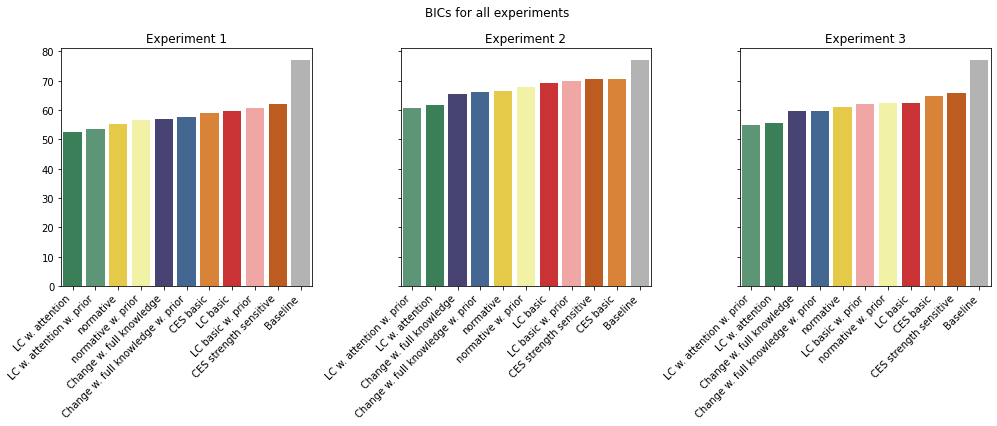

In [10]:

fig, axs = plt.subplots(1, len(experiments), figsize=(14, 6), sharey=True)

for i, experiment in enumerate(experiments):
    df_exp = df_bic[df_bic.experiment == experiment]
    df_exp_plot = df_exp[[col for col in df_exp.columns if col != 'experiment']]
    df_exp_plot = df_exp_plot[df_exp_plot.mean().sort_values().index]

    colors = gen_colors(df_exp_plot.columns, color_dict)
    sns.set_palette(colors)
    sns.barplot(data=df_exp_plot, ax=axs[i], ci=None)
    axs[i].set_xticklabels(df_exp_plot.columns, rotation=45, ha='right')
    axs[i].set_title(f'Experiment {experiment[-1]}')

fig.suptitle('BICs for all experiments')
plt.tight_layout()
plt.show()

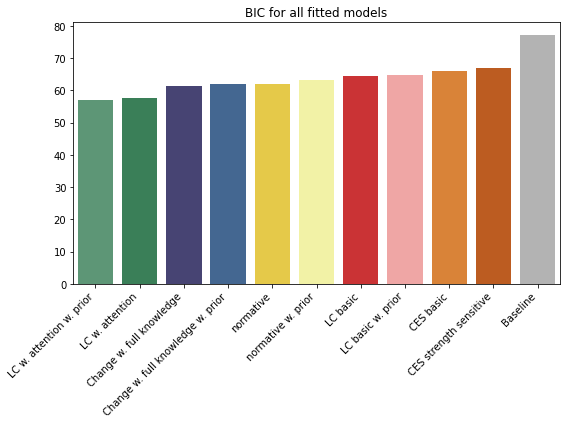

In [11]:
df_bic_plot = df_bic[[col for col in df_bic.columns if col != 'experiment']]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=ax, ci=None)
ax.set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
ax.set_title('BIC for all fitted models')
plt.tight_layout()
plt.show()

In [25]:
select_all = [
    'LC w. attention',
    'LC w. attention w. prior',
    #'Change w. full knowledge',
    #'Change w. full knowledge w. prior',
    'normative',
    'normative w. prior',
    'LC basic',
    'LC basic w. prior',
    'CES_strength_sensitive',
    'Baseline'
]
select_lc_attention = [
    'LC w. attention',
    'LC w. attention w. prior',
    'Baseline'
]
select_lc = [
    'LC basic',
    'LC basic w. prior',
    'Baseline'
]
select_change = [
    'Change w. full knowledge',
    'Change w. full knowledge w. prior',
    'Change linear cause effect',
    'Change linear cause'
    'Baseline'
]
select_normative = [
    'normative',
    'normative w. prior',
    'Baseline'
]
select_ces = [
    'CES_strength_sensitive',
    'Baseline'
]

selections = {
    'select_all' : [
        'LC w. attention w. prior',
        'LC w. attention',
        'Change w. full knowledge',
        'Change w. full knowledge w. prior',
        'normative',
        'normative w. prior',
        'LC basic',
        'LC basic w. prior',
        'CES basic',
        'CES strength sensitive',
        'Baseline'
    ],
    'select_best' : [
        'LC w. attention w. prior',
        'LC w. attention',
        #'Change w. full knowledge',
        #'Change w. full knowledge w. prior',
        'normative',
        'normative w. prior',
        'LC basic',
        'LC basic w. prior',
        'CES basic',
        'CES strength sensitive',
        'Baseline'
    ],
    'select_lc_attention' : [
        'LC w. attention',
        'LC w. attention w. prior',
        'Baseline'
    ],
    'select_lc' : [
        'LC basic',
        'LC basic w. prior',
        'Baseline'
    ],
    #'select_change' : [
    #    'Change w. full knowledge',
    #    'Change linear cause effect',
    #    'Change linear cause',
    #    'Baseline'
    #],
    'select_change_prior' : [
        'Change w. full knowledge',
        'Change w. full knowledge w. prior',
        'Baseline'
    ],
    'select_normative' : [
        'normative',
        'normative w. prior',
        'Baseline'
    ],
    'select_ces' : [
        'CES strength sensitive',
        'CES basic',
        'Baseline'
    ]
}

selections_titles = [
    'Local computations attention models prior comparison',
    'Local computations basic models prior comparison',
    'Change models prior comparison',
    'Normative models prior comparison',
    'Causal event segmentation models comparison'
]

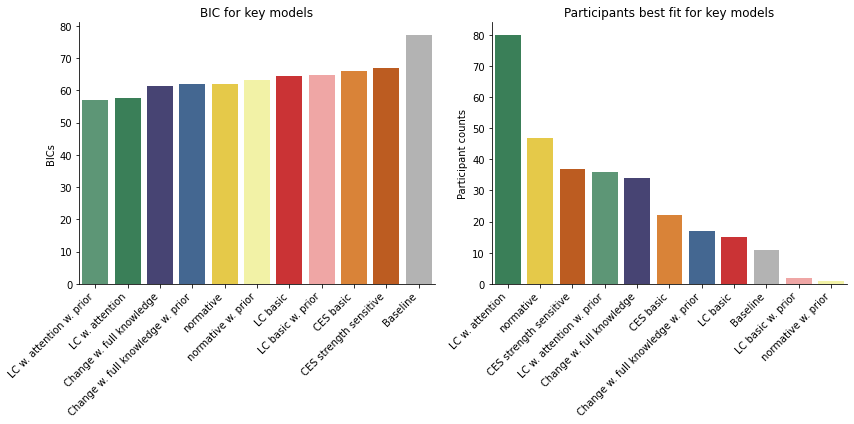

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
select = 'select_all'

# BICS
df_bic_plot = df_bic[[col for col in df_bic.columns if col not in ['experiment', 'best']]][selections[select]]

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=axs[0], ci=None)
axs[0].set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
axs[0].set_title('BIC for key models')

axs[0].set_ylabel('BICs')

# Participants' best fit

df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

df_bic_plot = df_bic[['best', 'experiment']]

df_order = pd.DataFrame(index=selections[select])
df_order['counts'] = 0
df_order.loc[df_bic_plot.best.value_counts().index, 'counts'] = df_bic_plot.best.value_counts().values

colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
sns.set_palette(colors)

sns.countplot(x='best', data=df_bic_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[1])

axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel('')

axs[1].set_title('Participants best fit for key models')

axs[1].set_ylabel('Participant counts')

sns.despine()
plt.tight_layout()
plt.show()

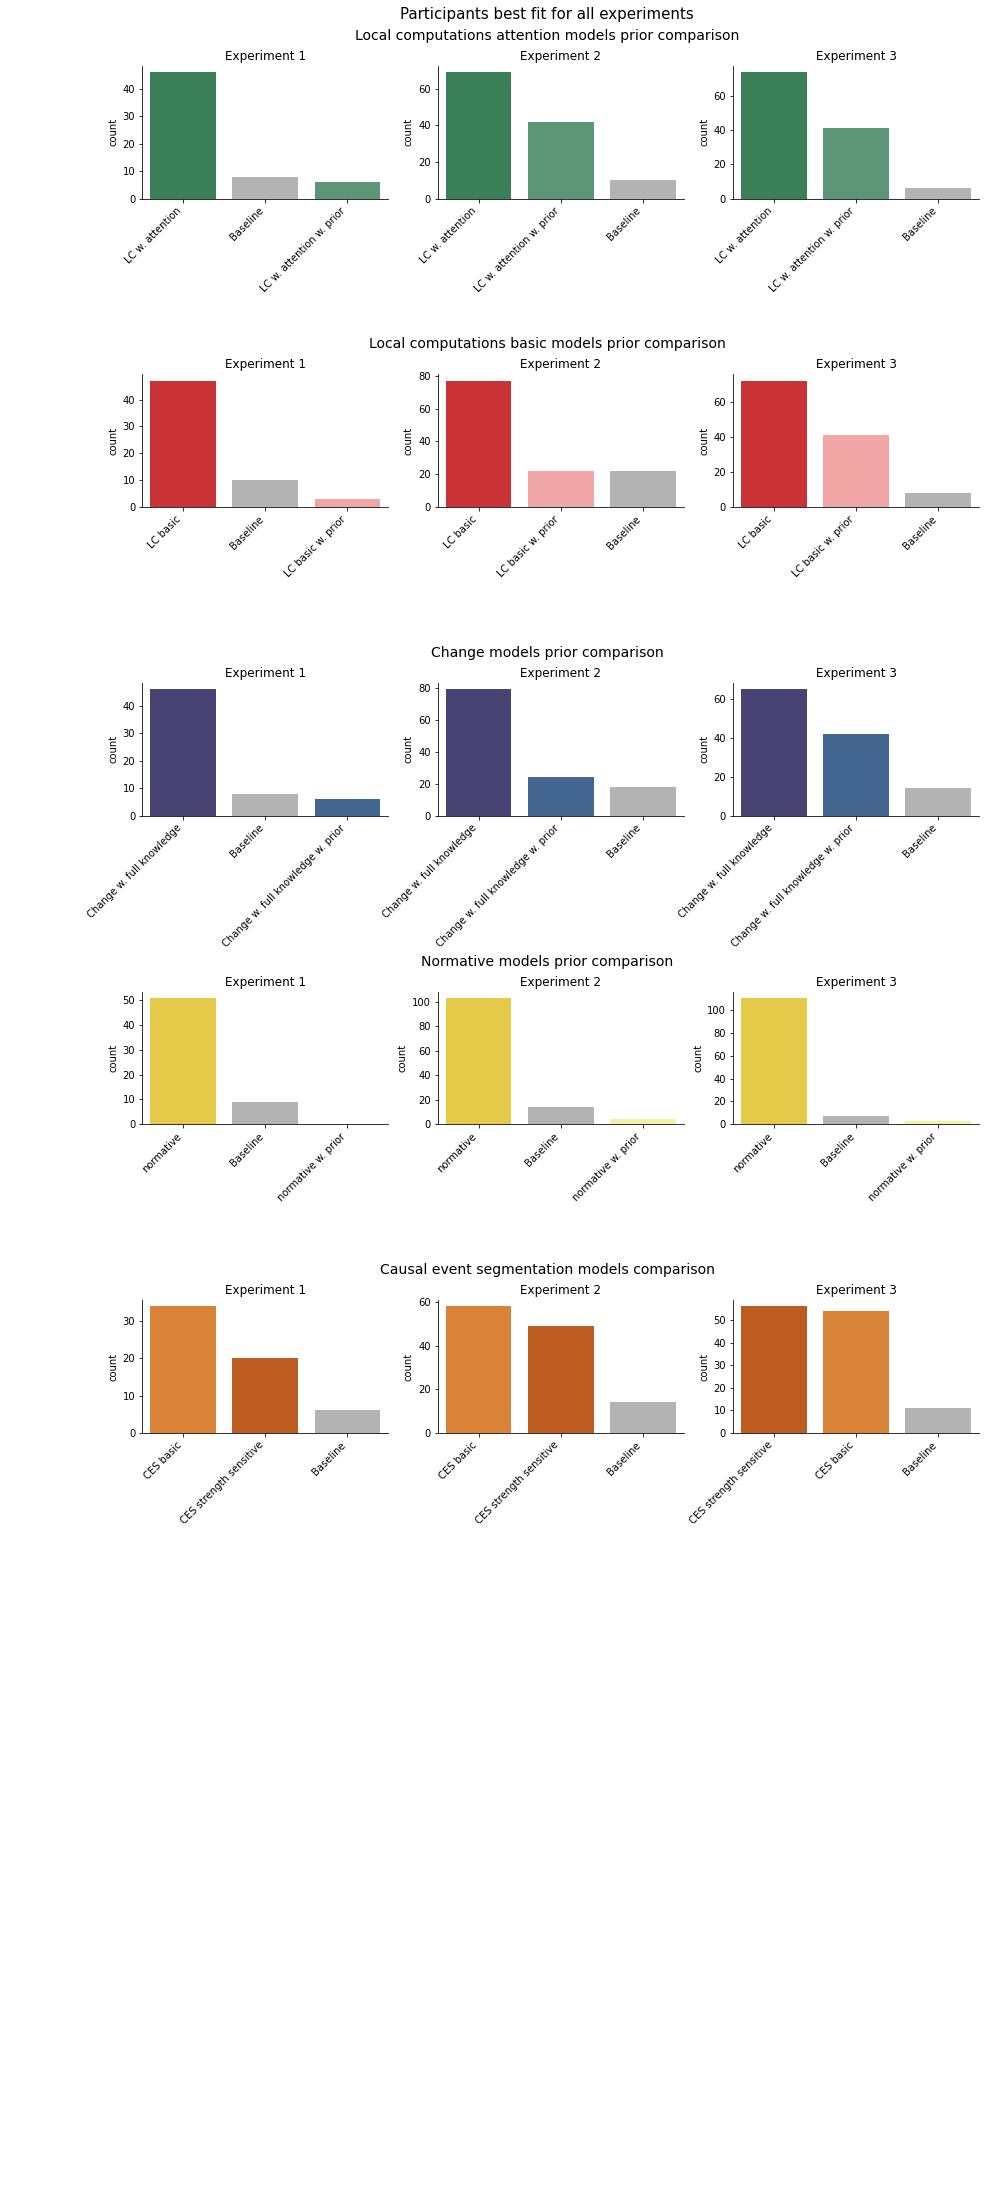

In [ ]:
#fig, axs = plt.subplots(len(selections), len(experiments), figsize=(15, 30))


fig = plt.figure(figsize=(15, 30))

subfigs = fig.subfigures(nrows=len(selections), ncols=1)
local_selections = [select for select in selections.keys() if select not in ['select_all', 'select_best']]
for i, select in enumerate(local_selections):
    subfigs[i].suptitle(f'{selections_titles[i]}', y=1, fontsize=14)

    axs = subfigs[i].subplots(nrows=1, ncols=len(experiments))
    
    df_bic['best'] = df_bic[selections[select]].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best'] = df_bic['best'].replace(np.arange(len(selections[select])), selections[select])

    subfigs[i].subplots_adjust(left=None, bottom=0.45, right=None, top=None, wspace=None, hspace=None)
    
    for j, experiment in enumerate(experiments):
        df_exp = df_bic[df_bic.experiment == experiment]
        df_exp_plot = df_exp[['best', 'experiment']]

        df_order = pd.DataFrame(index=selections[select])
        df_order['counts'] = 0
        df_order.loc[df_exp_plot.best.value_counts().index, 'counts'] = df_exp_plot.best.value_counts().values

        colors = gen_colors(df_order.counts.sort_values(ascending=False).index, color_dict)
        sns.set_palette(colors)

        sns.countplot(x='best', data=df_exp_plot, order=df_order.counts.sort_values(ascending=False).index, ax=axs[j])
        axs[j].set_xticklabels(axs[j].get_xticklabels(), rotation=45, ha='right')
        axs[j].set_xlabel('')
        axs[j].set_title(f'Experiment {experiment[-1]}')
        
        sns.despine(ax=axs[j])

fig.suptitle('Participants best fit for all experiments', fontsize=15, y=1.01)
#plt.tight_layout()
plt.show()

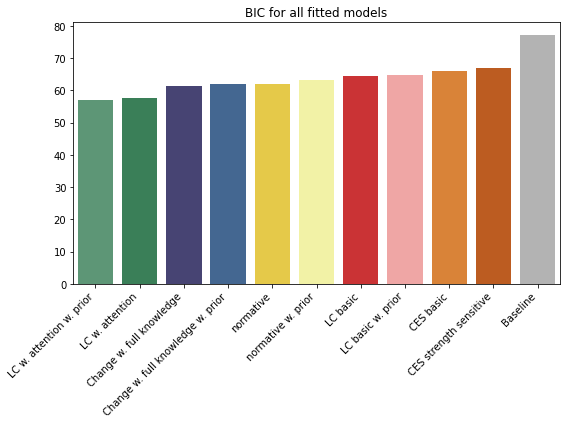

In [27]:
df_bic_plot = df_bic[[col for col in df_bic.columns if col not in ['experiment', 'best']]]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

colors = gen_colors(df_bic_plot.columns, color_dict)
sns.set_palette(colors)

sns.barplot(data=df_bic_plot, ax=ax, ci=None)
ax.set_xticklabels(df_bic_plot.columns, rotation=45, ha='right')
ax.set_title('BIC for all fitted models')
plt.tight_layout()
plt.show()

### Build table

- Columns: BIC group, parameters, BIC participant, participant best fit
- Index models

In [21]:



print(experiments)
df_params = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

for k, experiment in enumerate(experiments):
    df_group_exp = df_group[df_group.experiment == experiment]
    for i in df_group_exp.index:
        if df_group_exp.loc[i, 'model_name'] != 'Baseline':
            params_str = " ".join(df_group_exp.loc[i, 'params'][1:-1].split()).split(' ')

            params, indices = zip(*literal_eval(df_group_exp.loc[i, 'params_labels']))

            for j, idx in enumerate(indices):
                df_params[k].loc[df_group_exp.loc[i, 'model_name'], params[j]] = float(params_str[idx])
    
    df_params[k].loc['Baseline',:] = np.nan

df_params

dict_param_labels = {
    'smoothing': 'Tau',
    'decay_rate': 'Attention',
    'change_memory': 'Change memory',
    'prior_param': 'Tau Prior',
    'ce_threshold': 'CE threshold',
    'time_threshold': 'Strength threshold',
    'guess': 'Guess'
}

df_params = [df_exp.rename(dict_param_labels, axis=1) for df_exp in df_params]


['experiment_1' 'experiment_2' 'experiment_3']


In [22]:
df_params[1]

,Tau,Attention,Tau Prior,Change memory,CE threshold,Strength threshold,Guess
LC w. attention,1.676134,0.377738,NaN,NaN,NaN,NaN,NaN
LC w. attention w. prior,1.678605,0.448487,116.750428,NaN,NaN,NaN,NaN
Change w. full knowledge,1.509720,0.408657,NaN,0.314219,NaN,NaN,NaN
Change w. full knowledge w. prior,1.534999,0.405268,309.017044,0.314961,NaN,NaN,NaN
LC basic,1.175940,NaN,NaN,NaN,NaN,NaN,NaN
LC basic w. prior,1.175966,NaN,193.382788,NaN,NaN,NaN,NaN
normative,6.375059,NaN,NaN,NaN,NaN,NaN,NaN
normative w. prior,6.591797,NaN,308.306931,NaN,NaN,NaN,NaN
CES strength sensitive,NaN,NaN,NaN,NaN,0.560747,42.0,0.555635
CES basic,NaN,NaN,NaN,NaN,0.565209,NaN,0.573347


In [36]:
cols = ['BIC group', 'Tau', 'Attention', 'Change memory', 'Tau Prior', 'CE threshold', 'Strength threshold', 'Guess', 'BIC ind.', 'Part best fit all', 'Part best fit no change']
dfs_table = [pd.DataFrame(index=df_group[df_group.experiment == 'experiment_1'].model_name, columns=cols) for _ in experiments]

order_rows = [
    'Baseline',
    'normative',
    'normative w. prior',
    'LC basic',
    'LC basic w. prior',
    'CES basic',
    'CES strength sensitive',
    'LC w. attention',
    'LC w. attention w. prior',
    'Change w. full knowledge',
    'Change w. full knowledge w. prior'
]
for i, experiment in enumerate(experiments):
    dfs_table[i]['BIC group'] = df_group[df_group.experiment == experiment].bic.round().to_list()
    dfs_table[i]['BIC ind.'] = df_bic[df_bic.experiment == experiment][dfs_table[i].index].mean().round(2).to_list()

    #df_bic.best.value_counts()
    dfs_table[i][df_params[i].columns] = df_params[i].to_numpy().round(3)

    
    df_bic['best'] = df_bic[selections['select_all']].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best'] = df_bic['best'].replace(np.arange(len(selections['select_all'])), selections['select_all'])

    exp_best_all = df_bic[df_bic.experiment == experiment].best.value_counts().sort_values()
    dfs_table[i].loc[exp_best_all.index, 'Part best fit all'] = exp_best_all.round().to_list()

    df_bic['best'] = df_bic[selections['select_best']].apply(lambda x: np.argmin(x), axis=1)
    df_bic['best'] = df_bic['best'].replace(np.arange(len(selections['select_best'])), selections['select_best'])

    exp_best_no_change = df_bic[df_bic.experiment == experiment].best.value_counts().sort_values()
    dfs_table[i].loc[exp_best_no_change.index, 'Part best fit no change'] = exp_best_no_change.round().to_list()

    dfs_table[i] = dfs_table[i].loc[order_rows]
    
    dfs_table[i].to_csv(f'./data/final_outputs/exp{i+1}_bic_table.csv')

In [37]:
dfs_table[0]

,BIC group,Tau,Attention,Change memory,Tau Prior,CE threshold,Strength threshold,Guess,BIC ind.,Part best fit all,Part best fit no change
model_name,,,,,,,,,,,
Baseline,4616.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.25,3,4
normative,4265.0,7.658,NaN,NaN,NaN,NaN,NaN,NaN,55.36,9,9
normative w. prior,4250.0,7.661,NaN,NaN,272.899,NaN,NaN,NaN,56.74,NaN,NaN
LC basic,3753.0,1.609,NaN,NaN,NaN,NaN,NaN,NaN,59.58,2,2
LC basic w. prior,3746.0,1.610,NaN,NaN,450.459,NaN,NaN,NaN,60.59,1,1
CES basic,3766.0,NaN,NaN,NaN,NaN,0.625,NaN,0.437,58.90,6,7
CES strength sensitive,3579.0,NaN,NaN,NaN,NaN,0.744,48.398,0.400,62.06,13,13
LC w. attention,3256.0,2.150,0.208,NaN,NaN,NaN,NaN,NaN,52.55,14,20
LC w. attention w. prior,3282.0,2.134,0.046,NaN,212.443,NaN,NaN,NaN,53.48,4,4


In [ ]:
dfs_table[1]

,BIC group,Tau,Attention,Change memory,Tau Prior,CE threshold,Strength threshold,Guess,BIC ind.,Participants best fit
model_name,,,,,,,,,,
LC w. attention,7586.38,1.676134,0.377738,NaN,NaN,NaN,NaN,NaN,61.89,35
LC w. attention w. prior,7484.77,1.678605,0.448487,NaN,116.750428,NaN,NaN,NaN,60.79,14
Change w. full knowledge,8113.82,1.509720,0.408657,0.314219,NaN,NaN,NaN,NaN,65.40,14
Change w. full knowledge w. prior,8063.59,1.534999,0.405268,0.314961,309.017044,NaN,NaN,NaN,66.10,5
LC basic,8455.94,1.175940,NaN,NaN,NaN,NaN,NaN,NaN,69.40,2
LC basic w. prior,8421.51,1.175966,NaN,NaN,193.382788,NaN,NaN,NaN,70.03,NaN
normative,9177.77,6.375059,NaN,NaN,NaN,NaN,NaN,NaN,66.55,21
normative w. prior,9126.11,6.591797,NaN,NaN,308.306931,NaN,NaN,NaN,67.74,1
CES strength sensitive,8502.26,NaN,NaN,NaN,NaN,0.560747,42.0,0.555635,70.46,15


In [ ]:
dfs_table[2]

,BIC group,Tau,Attention,Change memory,Tau Prior,CE threshold,Strength threshold,Guess,BIC ind.,Participants best fit
model_name,,,,,,,,,,
LC w. attention,6893.11,1.973474,0.585802,NaN,NaN,NaN,NaN,NaN,55.64,31
LC w. attention w. prior,6734.30,1.993323,0.581962,NaN,259.551714,NaN,NaN,NaN,54.98,18
Change w. full knowledge,7508.71,1.765519,0.847596,0.301965,NaN,NaN,NaN,NaN,59.66,13
Change w. full knowledge w. prior,7447.71,1.837740,0.849361,0.301969,309.017044,NaN,NaN,NaN,59.78,11
LC basic,7708.59,1.542119,NaN,NaN,NaN,NaN,NaN,NaN,62.31,11
LC basic w. prior,7590.17,1.560797,NaN,NaN,427.772862,NaN,NaN,NaN,62.11,1
normative,9139.12,6.378391,NaN,NaN,NaN,NaN,NaN,NaN,61.02,17
normative w. prior,9101.24,6.377943,NaN,NaN,398.214873,NaN,NaN,NaN,62.26,NaN
CES strength sensitive,7842.11,NaN,NaN,NaN,NaN,0.633686,47.26939,0.466813,65.93,9
